# Summary
* Consolidate play,download and search feature dataframes to a holistic feature space on the uid level
* Missing value imputation- fill the NAs in the download and search features with zero since NA here means users don't have download or search activity in the given time window
* EDA of the created features- explor the relationship of download/search activities and play activities and check to see if frequency/recency featuers have apparently different distributions between the churned/active users

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from pyspark.sql import SparkSession

from pyspark.sql import Row
from pyspark.sql import functions

from pyspark.sql.functions import *
from pyspark.sql.types import *

In [2]:
spark = SparkSession.builder.appName("Music Box feature consolidation").getOrCreate()

### 1. Load all the feaure tables

In [3]:
play_ft = spark.read.csv('./intermediate tables/all_play_features/all_play_features.csv',header=True,inferSchema=True)

In [4]:
down_df = spark.read.csv('./intermediate tables/all_down_features/all_down_features.csv',header=True,inferSchema=True)

In [5]:
search_df = spark.read.csv('./intermediate tables/all_search_features/all_search_features.csv',header=True,inferSchema=True)

In [6]:
uid_label = spark.read.csv('./intermediate tables/valid_uid_label_all/valid_uid_label_all.csv',header=True,inferSchema=True)

In [7]:
uid_label.count()

139455

In [8]:
play_ft.count()

105351

In [10]:
search_df.count()

96638

In [11]:
down_df.count()

87866

### 2. Combine 4 dataframes together

In [9]:
all_features_df = play_ft.join(down_df,   on =['uid'], how='left')\
                         .join(search_df, on =['uid'], how='left')\
                         .join(uid_label, on =['uid'], how='left')

In [10]:
all_features_df.columns

['uid',
 'play_times_last_3_days',
 'play_times_last_7_days',
 'play_times_last_14_days',
 'play_times_last_21_days',
 'play_times_last_30_days',
 'avg_playtime_last_3_days',
 'avg_playtime_last_7_days',
 'avg_playtime_last_14_days',
 'avg_playtime_last_21_days',
 'avg_playtime_last_30_days',
 'days_since_last_play',
 'download_times_last_3_days',
 'download_times_last_7_days',
 'download_times_last_14_days',
 'download_times_last_21_days',
 'download_times_last_30_days',
 'days_since_last_download',
 'search_times_last_3_days',
 'search_times_last_7_days',
 'search_times_last_14_days',
 'search_times_last_21_days',
 'search_times_last_30_days',
 'days_since_last_search',
 'Churn']

In [9]:
pd.DataFrame(all_features_df.take(20),columns=all_features_df.columns)

,uid,play_times_last_3_days,play_times_last_7_days,play_times_last_14_days,play_times_last_21_days,play_times_last_30_days,avg_playtime_last_3_days,avg_playtime_last_7_days,avg_playtime_last_14_days,avg_playtime_last_21_days,...,download_times_last_21_days,download_times_last_30_days,days_since_last_download,search_times_last_3_days,search_times_last_7_days,search_times_last_14_days,search_times_last_21_days,search_times_last_30_days,days_since_last_search,Churn
0,114363528.0,0,0,0,1,20,0.000000,0.000000,0.000000,5.000000,...,6.0,14.0,12.0,0.0,0.0,0.0,0.0,8.0,30.0,1
1,167920832.0,9,22,354,560,817,517.333333,484.571429,4783.285714,5169.476190,...,2.0,7.0,12.0,0.0,1.0,3.0,12.0,29.0,7.0,0
2,168573152.0,0,0,0,0,109,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,12.0,30.0,1
3,57077508.0,216,372,1020,1510,2388,8823.000000,7222.714286,9382.285714,9921.809524,...,4.0,4.0,13.0,0.0,4.0,13.0,20.0,21.0,5.0,0
4,157815664.0,0,81,182,184,233,0.000000,2289.000000,2337.071429,1562.619048,...,0.0,2.0,23.0,0.0,0.0,0.0,0.0,2.0,23.0,1
5,159183408.0,0,1,77,223,707,0.000000,17.714286,722.928571,1201.428571,...,0.0,1.0,30.0,0.0,2.0,2.0,3.0,9.0,6.0,0
6,168013072.0,28,28,37,72,174,1624.333333,696.142857,475.071429,455.571429,...,0.0,48.0,22.0,0.0,0.0,0.0,7.0,24.0,20.0,0
7,168155632.0,13,42,85,207,399,554.666667,1023.428571,1044.857143,1482.285714,...,18.0,29.0,12.0,0.0,0.0,2.0,7.0,33.0,11.0,0
8,168353024.0,73,114,1921,2262,2876,1418.333333,1761.714286,3723.642857,4903.333333,...,38.0,53.0,15.0,0.0,0.0,2.0,66.0,124.0,14.0,0
9,167614368.0,0,0,0,0,70,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


### 3. Fill in missing values
* NA means the user did not do any search or download in the past 30 days. fill in NA with 0.

In [11]:
all_features_df2=all_features_df.fillna(0)

In [12]:
#check 
all_features_df2.where(col('download_times_last_14_days').isNull()).count()

0

In [13]:
all_features_df3=all_features_df2.toPandas()

In [14]:
all_features_df3.head()

,uid,play_times_last_3_days,play_times_last_7_days,play_times_last_14_days,play_times_last_21_days,play_times_last_30_days,avg_playtime_last_3_days,avg_playtime_last_7_days,avg_playtime_last_14_days,avg_playtime_last_21_days,...,download_times_last_21_days,download_times_last_30_days,days_since_last_download,search_times_last_3_days,search_times_last_7_days,search_times_last_14_days,search_times_last_21_days,search_times_last_30_days,days_since_last_search,Churn
0,114363528.0,0,0,0,1,20,0.000000,0.000000,0.000000,5.000000,...,6,14,12,0,0,0,0,8,30,1
1,167920832.0,9,22,354,560,817,517.333333,484.571429,4783.285714,5169.476190,...,2,7,12,0,1,3,12,29,7,0
2,168573152.0,0,0,0,0,109,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,12,30,1
3,57077508.0,216,372,1020,1510,2388,8823.000000,7222.714286,9382.285714,9921.809524,...,4,4,13,0,4,13,20,21,5,0
4,157815664.0,0,81,182,184,233,0.000000,2289.000000,2337.071429,1562.619048,...,0,2,23,0,0,0,0,2,23,1


### 4. Feature Exploration

#### 4.1 Is recency features indicative of churn?

In [15]:
recency_ft= all_features_df3.groupby('Churn')['days_since_last_search','days_since_last_play','days_since_last_download'].mean()

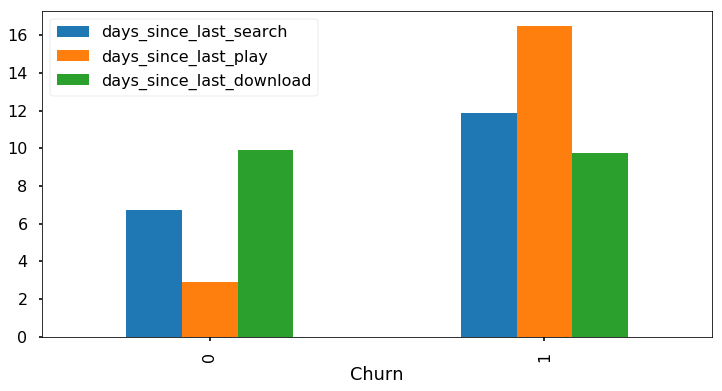

In [16]:
%matplotlib inline
plt.style.use('seaborn-poster')

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
recency_ft.plot(kind='bar',ax=ax)

> The average days since last play is significantly higher for churned users than active users

In [16]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


#### 4.2 Those who did not search or download in the past 30 days(download/search NA) are more likely to churn?

In [17]:
all_features_df_na= all_features_df.toPandas()

In [18]:
all_features_df_na.isnull().sum()

uid                                0
play_times_last_3_days             0
play_times_last_7_days             0
play_times_last_14_days            0
play_times_last_21_days            0
play_times_last_30_days            0
avg_playtime_last_3_days           0
avg_playtime_last_7_days           0
avg_playtime_last_14_days          0
avg_playtime_last_21_days          0
avg_playtime_last_30_days          0
days_since_last_play               0
download_times_last_3_days     17485
download_times_last_7_days     17485
download_times_last_14_days    17485
download_times_last_21_days    17485
download_times_last_30_days    17485
days_since_last_download       17485
search_times_last_3_days        9378
search_times_last_7_days        9378
search_times_last_14_days       9378
search_times_last_21_days       9378
search_times_last_30_days       9378
days_since_last_search          9378
Churn                              0
dtype: int64

In [19]:
down_search_na= all_features_df_na.loc[all_features_df_na.isnull().sum(axis=1)>=1, 'Churn']

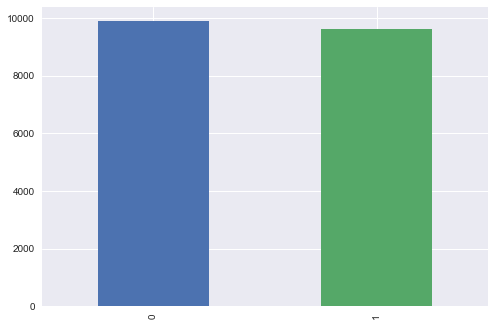

In [20]:
plt.style.use('seaborn')
down_search_na.value_counts().plot.bar() 

* there seems to be no indication of churn whether the user has download or search activities in the past 30 days or not

#### 4.3 How are those "no-download-or-search" users' play activities compare to those of the other users who have download and search activities in the past 30 days(download/search not NA)?

In [21]:
all_features_df_na['no_down_src']='Yes' #set default to yes

In [22]:
all_features_df_na['no_down_src'].loc[all_features_df_na.isnull().any(axis=1)]='No' 
#rows that has at least one NA --> no download or search activity in past 30 days

/Users/lalago31/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [23]:
play_act_compare=all_features_df_na.groupby('no_down_src')['play_times_last_21_days','play_times_last_14_days','play_times_last_7_days'].mean()

In [24]:
play_act_compare

,play_times_last_21_days,play_times_last_14_days,play_times_last_7_days
no_down_src,,,
No,114.720324,68.625801,30.001947
Yes,472.390262,299.729903,134.777892


Text(0.5,0,'Have download or search in the past 30 days?')

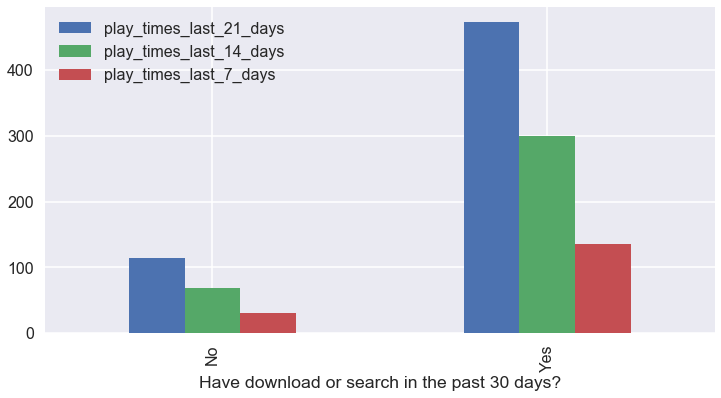

In [25]:
plt.style.use('seaborn-poster')

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
play_act_compare.plot(kind='bar',ax=ax)
plt.xlabel('Have download or search in the past 30 days?')

##### * The graph above shows users who have no download or search activities in the past 30 days have significantly fewer play times than those who have 

#### 4.4 More exploration of the relationship between play and download/search - Users who play more also download and search more?

In [67]:
df_21days = all_features_df3.loc[:,['play_times_last_21_days','download_times_last_21_days','search_times_last_21_days']]
play_21days_median = df_21days.play_times_last_21_days.median()
df_21days['play_times_last_21days_median'] = df_21days.play_times_last_21_days.apply(lambda x: 'over median' if x >= play_21days_median else 'below median')
down_srch_times = df_21days.groupby('play_times_last_21days_median')['download_times_last_21_days','search_times_last_21_days'].sum()

In [68]:
down_srch_times

,download_times_last_21_days,search_times_last_21_days
play_times_last_21days_median,,
below median,341121,484759
over median,1603427,2261602


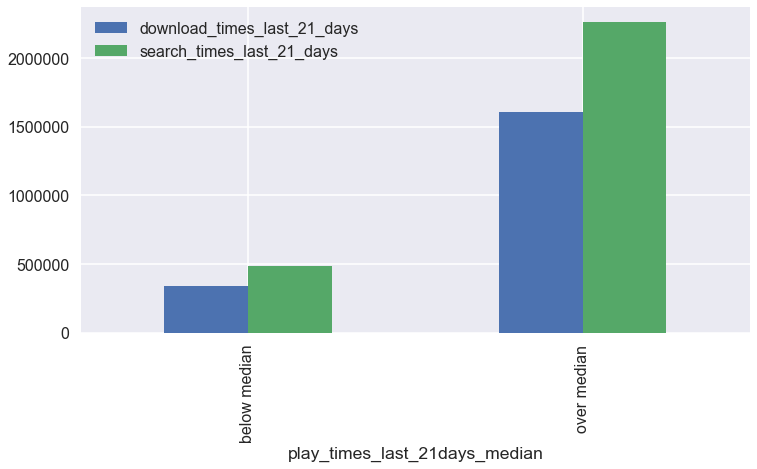

In [69]:
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
down_srch_times.plot(kind='bar',ax=ax)

#### * The graph above shows users who play more also download and search more and vice versa

#### 4.5 Can we tell if a user will churn 2 weeks in advance by looking at frequency features in the last 2 weeks?

In [103]:
frq_ft= all_features_df3.groupby('Churn')['play_times_last_14_days','download_times_last_14_days','search_times_last_14_days'].sum()

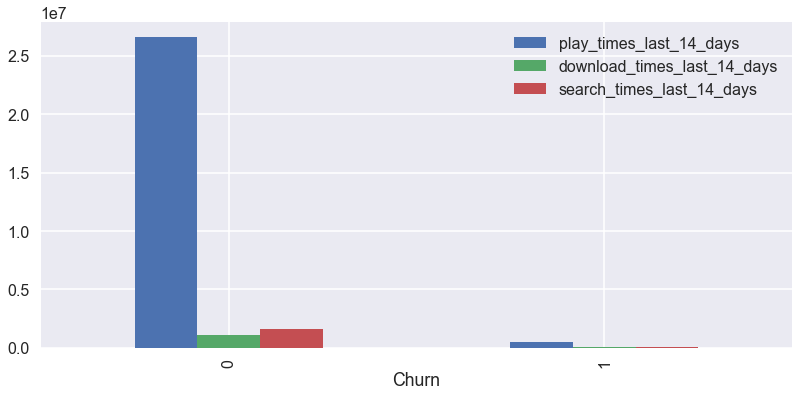

In [104]:
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
frq_ft.plot(kind='bar',ax=ax)

> play times for churn users are significantly lower than active users by looking at past 14 days behavior

#### What's the distribution of average play per day?

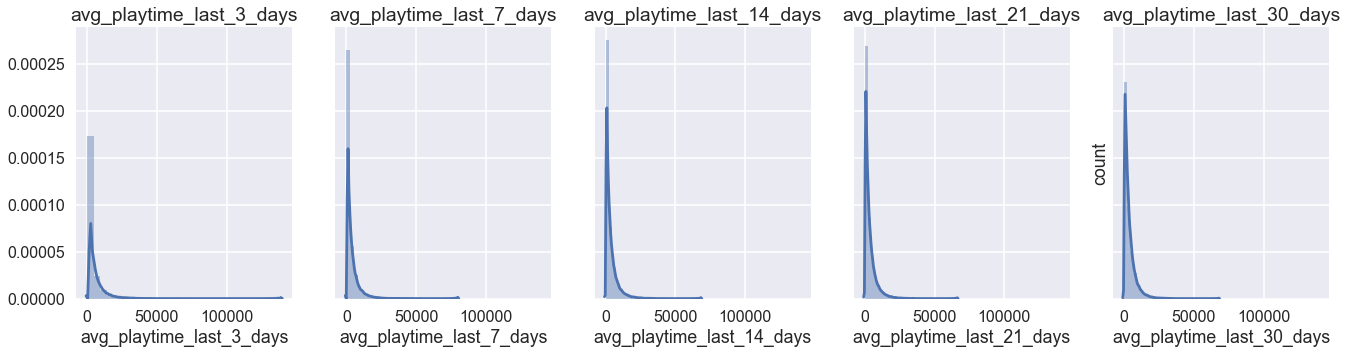

In [106]:
f, axs = plt.subplots(1,5, sharex = True, sharey=True, figsize = (20,5))
window_list=[3,7,14,21,30]
for w in window_list:
    i = window_list.index(w)
    colname = 'avg_playtime_last_' + str(w) + '_days'
    plt.xlabel("average play time")
    plt.ylabel('count')
    sns.distplot(all_features_df3[colname],ax = axs[i], bins = 30)

    axs[i].set_title(colname)


In [105]:
all_features_df3.to_csv('./intermediate tables/all_features_label_combined.csv', index=False, header=True)